# <center> Homework 2

In [7]:
import itertools
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.patches import Ellipse

import warnings
warnings.filterwarnings('ignore')

### 1. Classification: K-means, and the EM algorithm

In [95]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:, :]
Y = iris.target

In [85]:
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal as mn

In [136]:
class Diagonal_GMM():
    
    def __init__(self, K, max_iter=100):
        self.K = K                      
        self.max_iter = max_iter
        
    def initialize(self,X):
        self.n, self.d = X.shape[0], X.shape[1]      
        self.pi = 1/K*np.ones(self.K)    
        self.to = 1/K*np.ones((self.n, self.K))
        self.mu = X[np.random.randint(low=0, high=self.n, size=self.K),:]
        
        self.sigma = np.array([np.eye(self.d)]*self.K)
        kmeans = KMeans(n_clusters=self.K, random_state=0).fit(X)
        labels = kmeans.predict(X)
        unique, count = np.unique(labels,return_counts=True)
        for k in range(self.K):
            self.mu[k] = np.mean(X[np.where(labels == k)],axis=0)
            self.pi[k] = count[k]/self.n
        
    def E_step(self, X):
        self.to = self.predict_probability(X)
        self.pi = self.to.mean(axis=0)
        
    def M_step(self, X):
        for k in range(self.K):
            to = self.to[:, k]
            self.pi[k]=1/self.n*to.sum()
            self.mu[k,:]= np.multiply(X,to.reshape(self.n,1)).sum(axis=0)/to.sum()
            self.sigma[k,:,:]= np.diag(np.multiply((X-self.mu[k,:])**2,to.reshape(self.n,1)).sum(axis=0)/to.sum()) 
            
    def fit(self,X):
        self.initialize(X)
        it = 0
        while it <= self.max_iter:
            self.E_step(X)
            self.M_step(X)
            it += 1
            
    def predict_probability(self, X):
        p = np.zeros((self.n, self.K))
        for k in range(self.K):
            p[:,k] = self.pi[k]*mn.pdf(X, self.mu[k,:], self.sigma[k,:,:])
        return np.multiply(p, (1/np.sum(p,axis=1)).reshape(self.n,1))
    
    def predict(self, X):
        p = self.predict_probability(X)
        return np.argmax(p, axis=1)

In [89]:
from scipy import linalg

In [119]:
def plot_ellipse(X, Y, K, ax):
    L = []
    means = []
    for k in range(K):
        L.append(np.cov(X[Y == k, 0], X[Y == k, 1]))
        means.append(np.mean(X[Y==k],axis=0))
        
    covariances = np.array(L) 
    means = np.array(means)
    for i, (mean, covar) in enumerate(zip(means, covariances)):
        v, w = linalg.eigh(covar)
        v = 3 * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])

        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle,color='blue')
        ell.set_facecolor('none')
        
        ell.set_alpha(0.9)
        ax.add_artist(ell)

In [155]:
def plot_ground_truth(X, Y):
    plt.figure(figsize=(20,10))
    
    ax = plt.subplot(231)
    a,b= X[:,0], X[:,1]
    ax.scatter(a, b, c=Y, s=40, cmap=plt.cm.viridis, alpha=0.4)
    plt.xticks(())
    plt.yticks(())
    ax.set_title('Ground truth clusters \n with respect to the coordinates (1,2)')
    
    ax = plt.subplot(232)
    a,b= X[:,0], X[:,2]
    ax.scatter(a, b, c=Y, s=40, cmap=plt.cm.viridis, alpha=0.4)
    plt.xticks(())
    plt.yticks(())
    ax.set_title('Ground truth clusters \n with respect to the coordinates (1,3)')
    
    ax = plt.subplot(233)
    a,b= X[:,0], X[:,3]
    ax.scatter(a, b, c=Y, s=40, cmap=plt.cm.viridis, alpha=0.4)
    plt.xticks(())
    plt.yticks(())
    ax.set_title('Ground truth clusters \n with respect to the coordinates (1,4)')
    
    ax = plt.subplot(234)
    a,b= X[:,1], X[:,2]
    ax.scatter(a, b, c=Y, s=40, cmap=plt.cm.viridis, alpha=0.4)
    plt.xticks(())
    plt.yticks(())
    ax.set_title('Ground truth clusters \n with respect to the coordinates (2,3)')
    
    ax = plt.subplot(235)
    a,b= X[:,1], X[:,3]
    ax.scatter(a, b, c=Y, s=40, cmap=plt.cm.viridis, alpha=0.4)
    plt.xticks(())
    plt.yticks(())
    ax.set_title('Ground truth clusters \n with respect to the coordinates (2,4)')
    
    ax = plt.subplot(236)
    a,b= X[:,2], X[:,3]
    ax.scatter(a, b, c=Y, s=40, cmap=plt.cm.viridis, alpha=0.4)
    plt.xticks(())
    plt.yticks(())
    ax.set_title('Ground truth clusters \n with respect to the coordinates (3,4)')

In [156]:
def plots(model, X):
    plt.figure(figsize=(20,10))
    labels = model.predict(X)
    
    ax = plt.subplot(231)
    a,b= X[:,0], X[:,1]
    ax.scatter(a, b, c=labels, s=40, cmap=plt.cm.viridis, alpha=0.4)
    arr=np.array([a,b]).T
    plot_ellipse(arr,labels,K,ax)
    plt.xticks(())
    plt.yticks(())
    ax.set_title('Predicted clusters using '+model.__class__.__name__+'\n with respect to the coordinates (1,2)')
    
    ax=plt.subplot(232)
    a,b= X[:,0], X[:,2]
    ax.scatter(a, b, c=labels, s=40, cmap=plt.cm.viridis, alpha=0.4);
    arr=np.array([a,b]).T
    plot_ellipse(arr,labels,K,ax)
    plt.xticks(())
    plt.yticks(())
    ax.set_title('Predicted clusters using '+model.__class__.__name__+'\n with respect to the coordinates (1,3)')
    
    ax=plt.subplot(233)
    a,b= X[:,0], X[:,3]
    ax.scatter(a, b, c=labels, s=40, cmap=plt.cm.viridis, alpha=0.4);
    arr=np.array([a,b]).T
    plot_ellipse(arr,labels,K,ax)
    plt.xticks(())
    plt.yticks(())
    ax.set_title('Predicted clusters using '+model.__class__.__name__+'\n with respect to the coordinates (1,4)')
    
    ax = plt.subplot(234)
    a,b= X[:,1], X[:,2]
    ax.scatter(a, b, c=labels, s=40, cmap=plt.cm.viridis, alpha=0.4);
    arr=np.array([a,b]).T
    plot_ellipse(arr,labels,K,ax)
    plt.xticks(())
    plt.yticks(())
    ax.set_title('Predicted clusters using '+model.__class__.__name__+'\n with respect to the coordinates (2,3)')
    
    ax=plt.subplot(235)
    a,b= X[:,1], X[:,3]
    ax.scatter(a, b, c=labels, s=40, cmap=plt.cm.viridis, alpha=0.4);
    arr=np.array([a,b]).T
    plot_ellipse(arr,labels,K,ax)
    plt.xticks(())
    plt.yticks(())
    ax.set_title('Predicted clusters using '+model.__class__.__name__+'\n with respect to the coordinates (2,4)')
    
    ax = plt.subplot(236)
    a,b= X[:,2], X[:,3]
    ax.scatter(a, b, c=labels, s=40, cmap=plt.cm.viridis, alpha=0.4);
    arr=np.array([a,b]).T
    plot_ellipse(arr,labels,K,ax)
    plt.xticks(())
    plt.yticks(())
    ax.set_title('Predicted clusters using '+model.__class__.__name__+'\n with respect to the coordinates (3,4)')

#### Iris Dataset ground truth

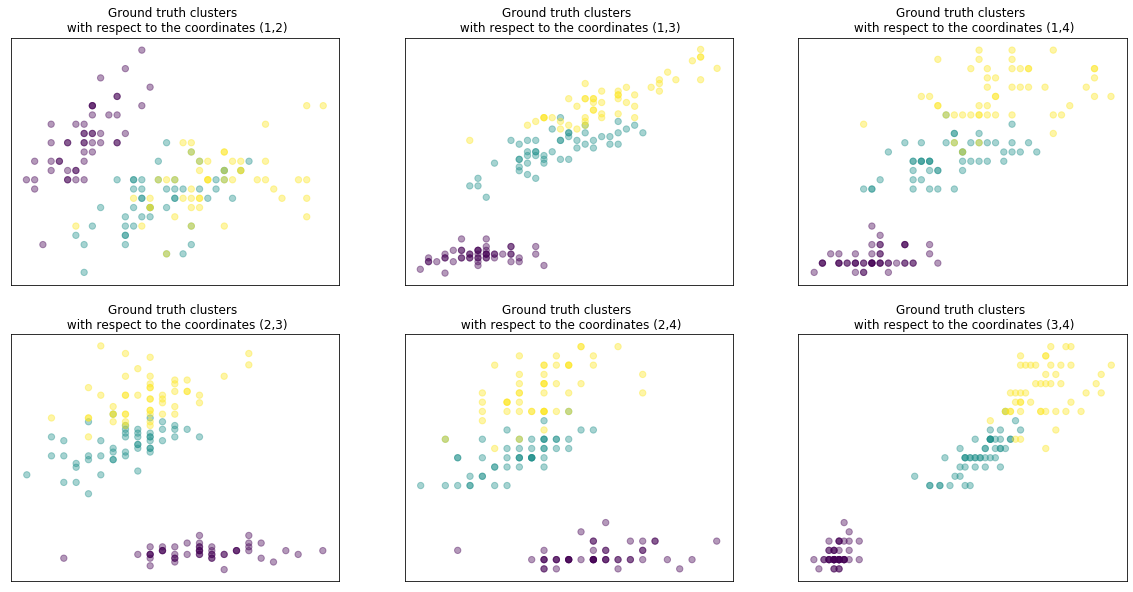

In [157]:
plot_ground_truth(X,Y)

#### Results comparison between Kmeans, GMM and Diagonal GMM on Iris Dataset

#### Number of clusters K = 2

In [158]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [159]:
K = 2

kmeans = KMeans(n_clusters=K, random_state=0)
kmeans.fit(X)

GMM = GaussianMixture(n_components=K)
GMM.fit(X)

DGMM = Diagonal_GMM(K)
DGMM.fit(X)

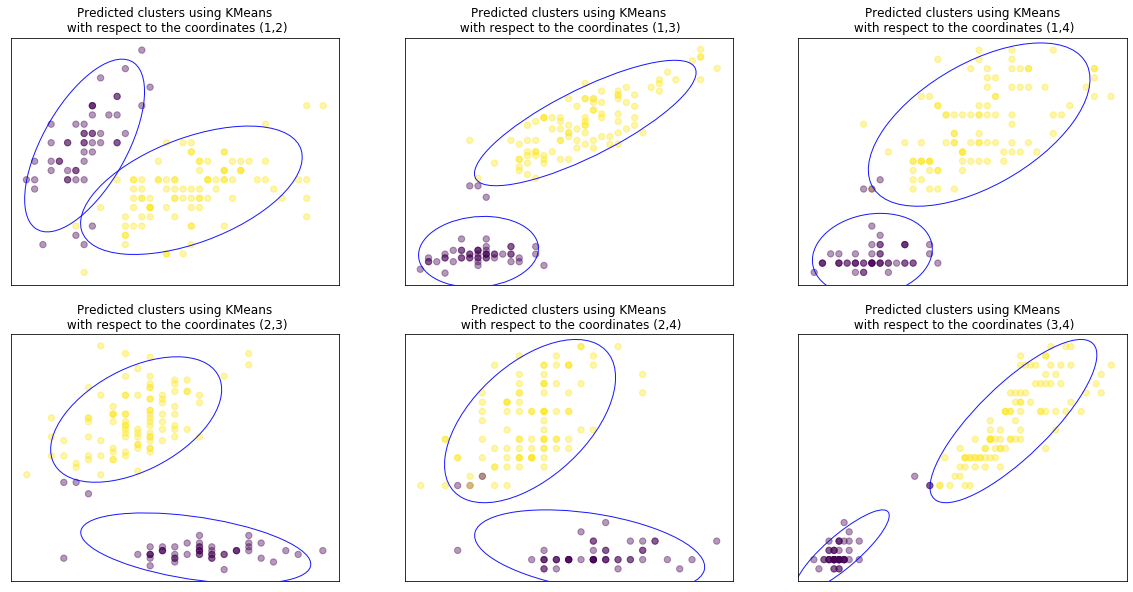

In [160]:
plots(kmeans,X)

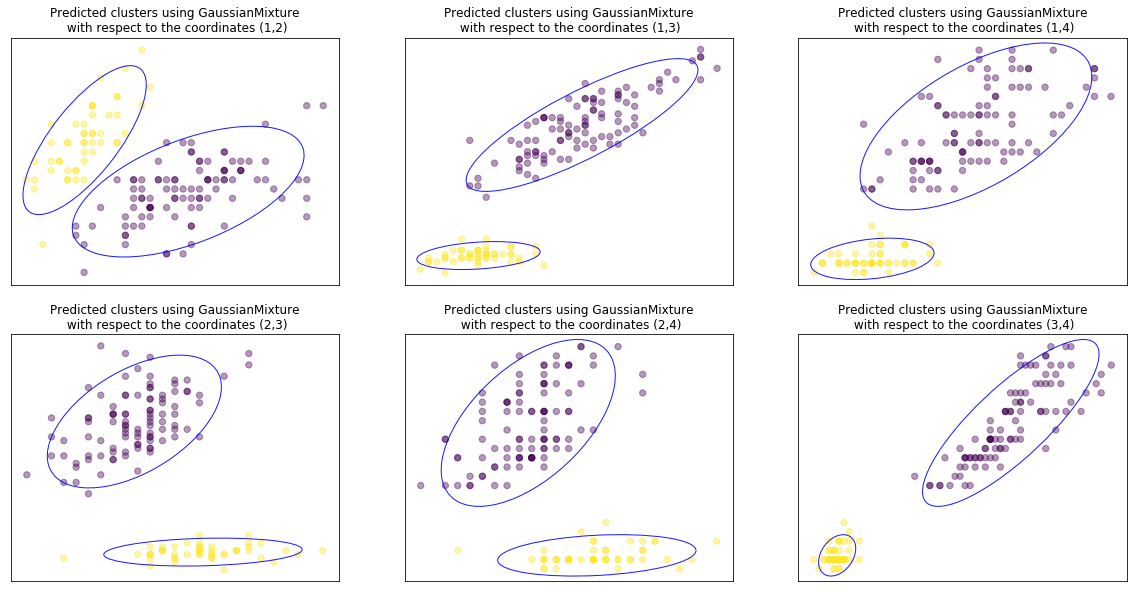

In [161]:
plots(GMM,X)

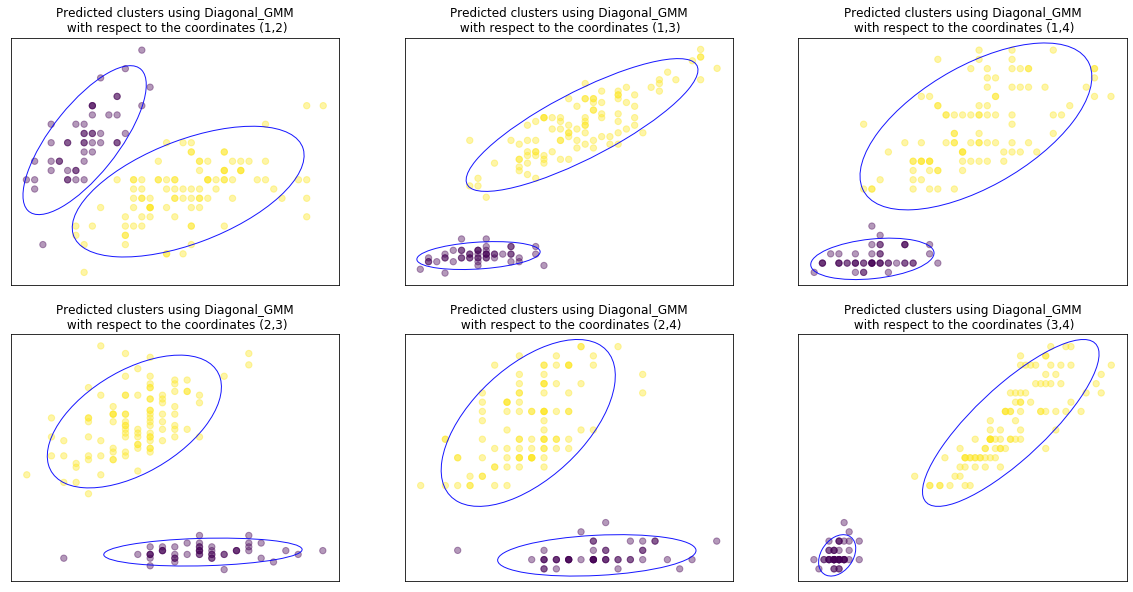

In [162]:
plots(DGMM,X)

#### Number of clusters K = 3

In [163]:
K = 3

kmeans = KMeans(n_clusters=K, random_state=0)
kmeans.fit(X)

GMM = GaussianMixture(n_components=K)
GMM.fit(X)

DGMM = Diagonal_GMM(K)
DGMM.fit(X)

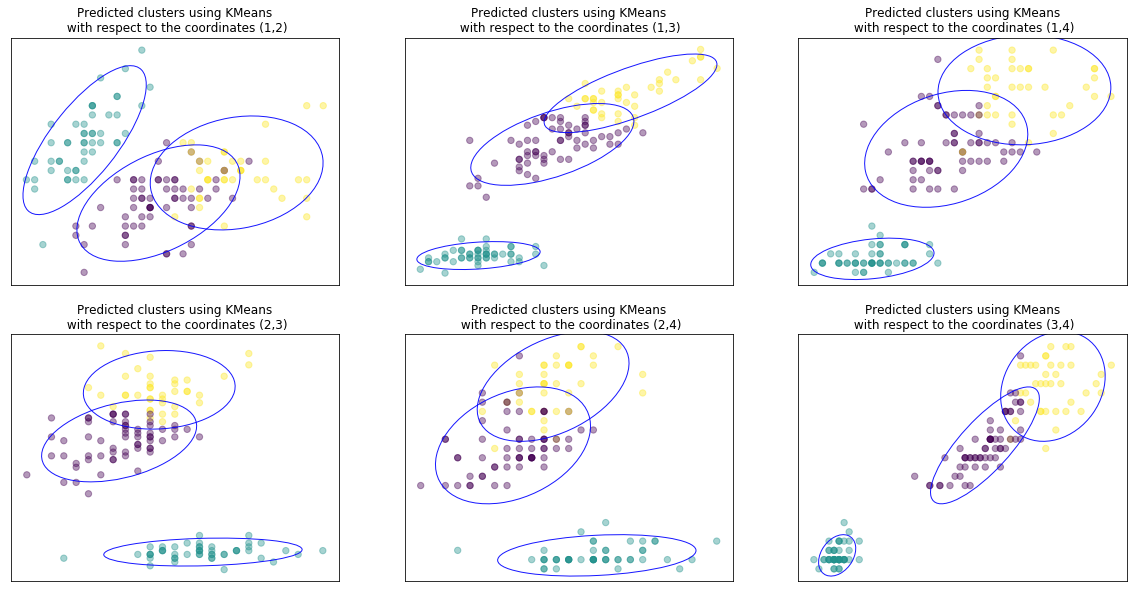

In [164]:
plots(kmeans,X)

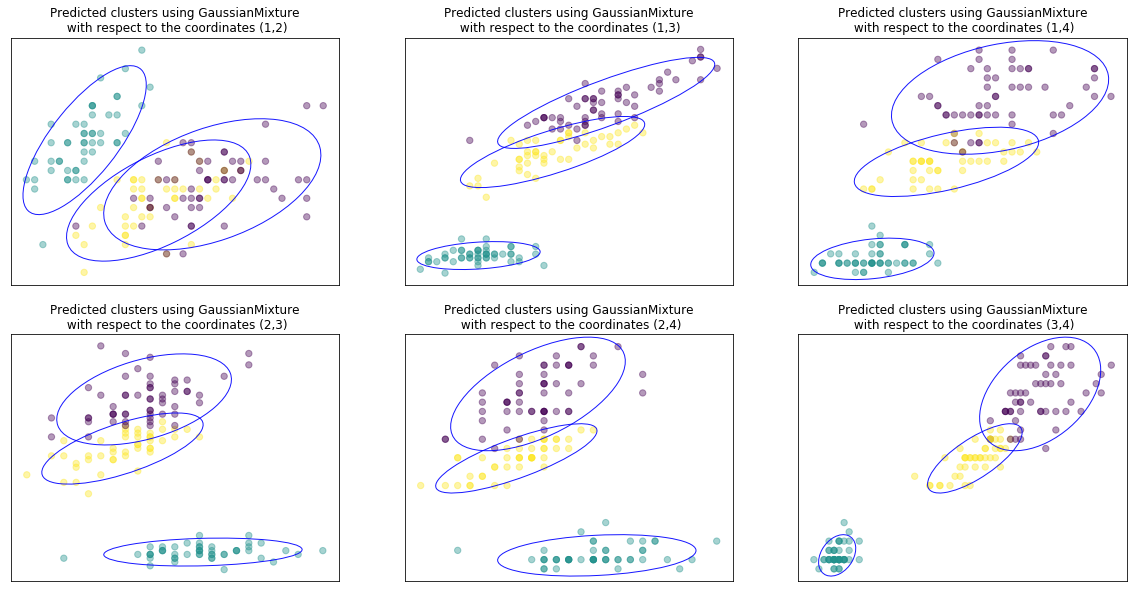

In [165]:
plots(GMM,X)

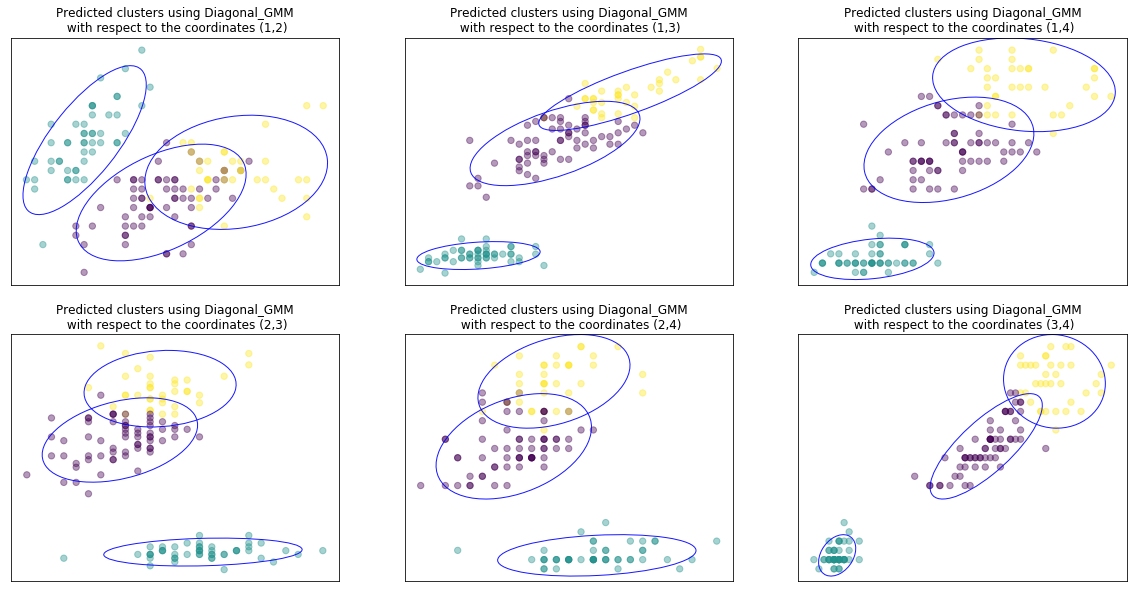

In [166]:
plots(DGMM,X)

#### Number of clusters K = 4

In [167]:
K = 4

kmeans = KMeans(n_clusters=K, random_state=0)
kmeans.fit(X)

GMM = GaussianMixture(n_components=K)
GMM.fit(X)

DGMM = Diagonal_GMM(K)
DGMM.fit(X)

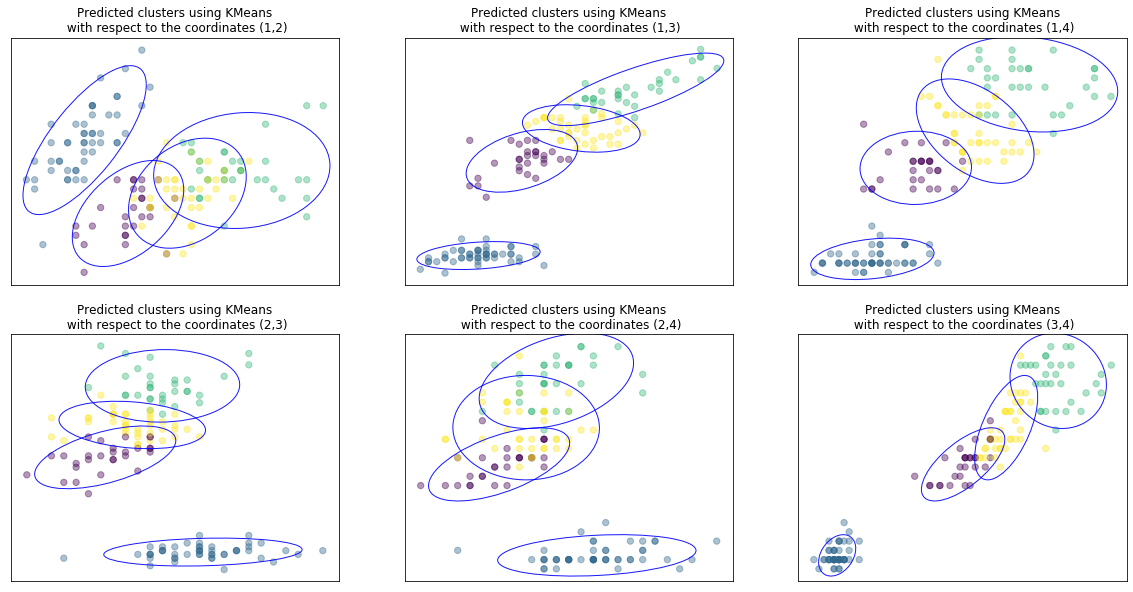

In [168]:
plots(kmeans,X)

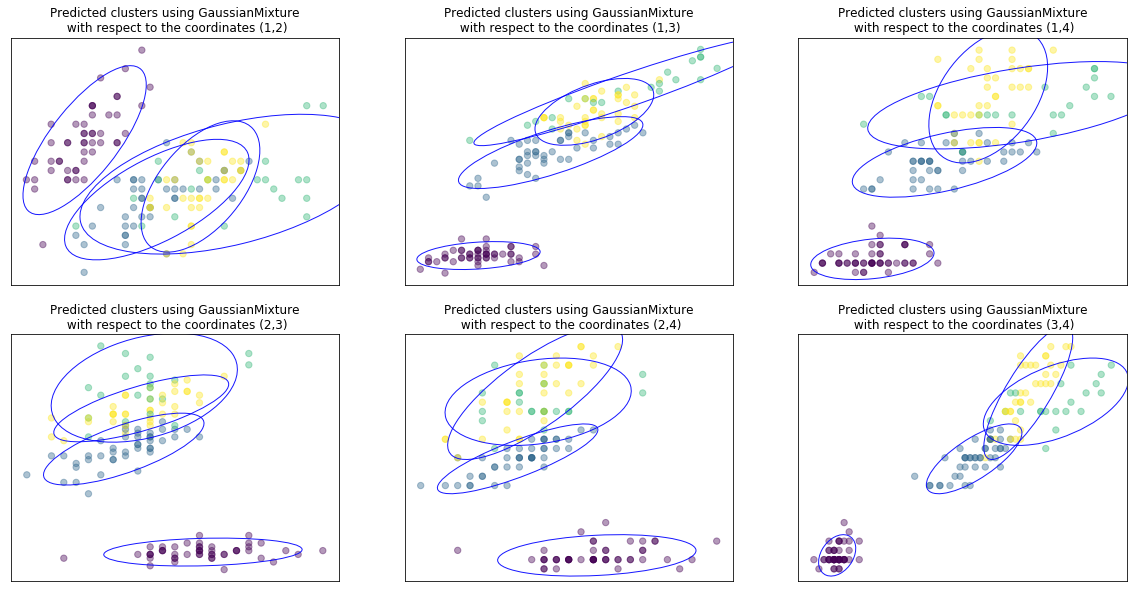

In [169]:
plots(GMM,X)

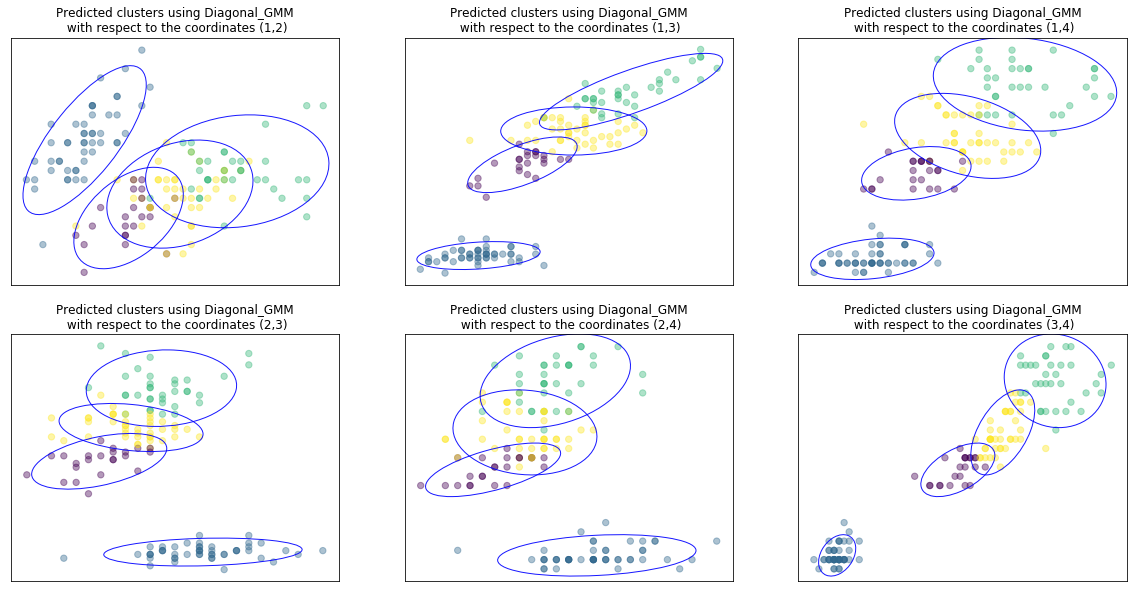

In [170]:
plots(DGMM,X)

#### Results comparison between Kmeans, GMM and Diagonal GMM on Synthetic Data

In [205]:
d1 = np.random.multivariate_normal(np.array([2, 2]), np.array([[10.0, 0.0], [0.0, 0.1]]), 200)
d2 = np.random.multivariate_normal(np.array([4, 4]), np.array([[0.01, 0.0], [0.0, 3.0]]), 200)
d3 = np.random.multivariate_normal(np.array([-1, -1]), np.array([[10.0, 0.0], [0.0, .5]]), 200)
labels = np.array([0]*len(d1) + [1]*len(d2) + [2]*len(d3))
synthetic_X = np.concatenate([d1/3.0, d2/3.0, d3/3.0], axis=0)

In [208]:
kmeans = KMeans(n_clusters=3, max_iter=200)
kmeans.fit(synthetic_X)

GMM = GaussianMixture(n_components=3)
GMM.fit(synthetic_X)

DGMM = Diagonal_GMM(3)
DGMM.fit(synthetic_X)

In [203]:
def plot_ground_truth(synthetic_X, labels):
    plt.figure(figsize=(20,10))
    plt.subplot(231)
    plt.scatter(synthetic_X[:, 0], synthetic_X[:, 1], c=labels)
    plt.title("Ground truth clustering")
    plt.xticks(())
    plt.yticks(())

In [195]:
def plot_synthetic_data_clustering(model,X):
    plt.figure(figsize=(20,10))
    labels = model.predict(X)
    
    ax = plt.subplot(231)
    a,b= X[:,0], X[:,1]
    ax.scatter(a, b, c=labels, s=40, cmap=plt.cm.viridis, alpha=0.4)
    arr=np.array([a,b]).T
    plt.xticks(())
    plt.yticks(())

    ax.set_title('Predicted clusters using '+model.__class__.__name__+'\n with respect to X')

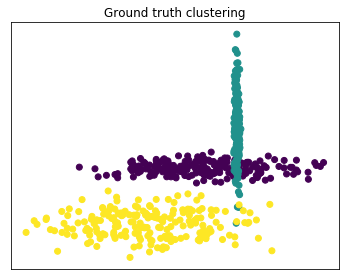

In [204]:
plot_ground_truth(synthetic_X, labels)

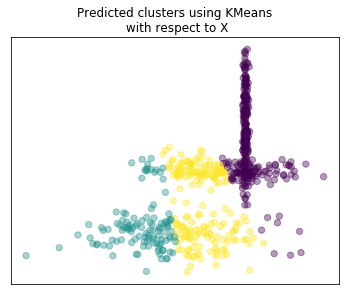

In [192]:
plot_synthetic_data_clustering(kmeans, synthetic_X)

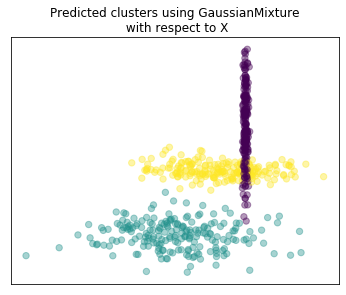

In [193]:
plot_synthetic_data_clustering(GMM, synthetic_X)

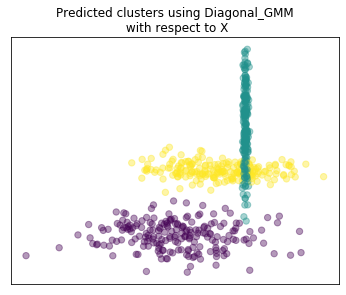

In [194]:
plot_synthetic_data_clustering(DGMM, synthetic_X)

### 2. Graphs, algorithms and Ising

#### 1. Sum-Product Algorithm for an Undirected Chain

In [77]:
class SPA():            
    
    def __init__(self, X, single_potential, joint_potential):
        n, K = X.shape # X is an np.array of shape (n,K)
        self.f_messages = np.zeros((n-1,K))
        self.b_messages = np.zeros((n-1,K))
        self.marginal_distribution_ = np.zeros((n,K))
        
    def forward_message(self):
        n, K = X.shape
        
        self.f_messages[0,:] = np.dot(single_potential(X[0]), joint_potential(X[0],X[1]))
        for i in range(1,n-1):
            self.f_messages[i,:] = np.dot(single_potential(X[i])*self.f_messages[i-1,:], joint_potential(X[i],X[i+1]))
        
        return self.f_messages
    
    def backward_message(self):
        n, K = X.shape
        
        self.b_messages[n-2,:] = np.dot(single_potential(X[n-1]), joint_potential(X[n-2],X[n-1]))
        for i in range(n-3, -1, -1):
            self.b_messages[i,:] = np.dot(single_potential(X[i+1])*self.b_messages[i+1,:], joint_potential(X[i],X[i+1]))
        
        return self.b_messages
    
    def marginal_distribution(self):
        n, K = X.shape
        forward_msg  = self.forward_message()
        backward_msg = self.backward_message()
        
        for j in range(1,n-1):
            self.marginal_distribution_[j] = single_potential(X[j])*forward_msg[j-1]*backward_msg[j]
        self.marginal_distribution_[0]   = single_potential(X[0])*backward_msg[0]
        self.marginal_distribution_[n-1] = single_potential(X[n-1])*forward_msg[n-2]
        Z = np.sum(self.marginal_distribution_, axis=1)[0]
        
        return self.marginal_distribution_/Z
    
    def Z(self):
        n, K = X.shape
        forward_msg  = self.forward_message()
        backward_msg = self.backward_message()
        
        for j in range(1,n-1):
            self.marginal_distribution_[j] = single_potential(X[j])*forward_msg[j-1]*backward_msg[j]
        self.marginal_distribution_[0]   = single_potential(X[0])*backward_msg[0]
        self.marginal_distribution_[n-1] = single_potential(X[n-1])*forward_msg[n-2]
        Z = np.sum(self.marginal_distribution_, axis=1)[0]
        
        return Z

#### 2. Ising Model

In [78]:
class SPA():            
    
    def __init__(self, X, single_potential, joint_potential):
        
        self.N, self.K = X.shape                   
        self.f_messages_ = np.zeros((self.N,self.K))
        self.b_messages_ = np.zeros((self.N,self.K))
        self.marginal_distribution_ = np.zeros((self.N,self.K))
    
    def log_forward_message(self):
        x = X[0]
        log_A = np.log(joint_potential(x,x))
        log_b = np.log(single_potential(x))
      
        for n in range(1,self.N):
            mu = self.f_messages_[n-1]
            a  = np.max(np.add(log_A, log_b+mu),axis=0)
            self.f_messages_[n] = a + np.log(np.sum(np.exp(np.add(log_A, log_b-a+mu)),axis=0))
    
    def log_backward_message(self):
        x = X[0]
        log_A = np.log(joint_potential(x,x))
        log_b = np.log(single_potential(x))
        
        for n in range(1,self.N):
            beta = self.b_messages_[-n]
            c = np.max(np.add(log_A, log_b+beta),axis=0)
            self.b_messages_[-1-n] = c + np.log(np.sum(np.exp(np.add(log_A, log_b-c+beta)),axis=0))
    
    def log_Z(self):
        x = X[0]
        self.log_forward_message()
        u = self.f_messages_[-1] + np.log(single_potential(x))
        z = np.max(u)
        Z = z + np.log(np.sum(np.exp(u-z)))
        
        return Z
    
    def marginal_distribution(self):
        mu_alpha_prime  = self.log_forward_message()
        mu_beta_prime = self.log_backward_message()
        p_prime = mu_alpha_prime + mu_beta_prime + np.log(np.array([single_potential(X) for k in range(self.N)]))
        log_Z = self.log_Z()
        self.marginal_distribution_ = p_prime - log_Z

In [79]:
def binary_representation(x,w):    
    result = [int(i) for i in list(bin(x)[2:])]
    if len(result) != w:
        result = [0]*(w-len(result)) + result
    return result

binary_representation = np.vectorize(binary_representation)

def single_potential(x):
    x = binary_representation(x,w)
    return np.exp(alpha*np.sum(x)+beta*np.sum(x[:-1]==x[1:]))

def joint_potential(x,y):
    x = binary_representation(x,w)
    y = binary_representation(y,w)
    return np.exp(beta*np.sum(x==y))

single_potential = np.vectorize(single_potential)
joint_potential  = np.vectorize(joint_potential)

In [9]:
alpha, beta = 0, 1
h, w = 100, 10
X = np.tile(np.arange(0,2**w), reps=h).reshape(h,2**w)

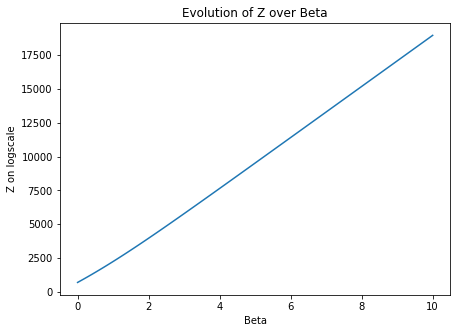

In [82]:
betas = np.linspace(0., 10., 100)
log_Z = np.zeros(100)

for i, beta in enumerate(betas):
    ising_model = SPA(X, single_potential, joint_potential)
    log_Z[i]    = ising_model.log_Z()

plt.figure(figsize=(7,5))
plt.plot(betas, log_Z)
plt.xlabel("Beta")
plt.ylabel("Z on logscale")
plt.title('Evolution of Z over Beta')

plt.show()

##### Q3. Loopy Belief Model :

In [1]:
def neighbors(X):
    n=len(X)
    N=[[] for i in range(n)]
    for j in range(n):
        if abs(X[i][0]-X[j][0])== 1  or abs(X[i][1]-X[j][1])== 1  :
            N[i].append(j)
    return N
def neighbor_except(N,i,j): 
    ### Neighbors of i except j
    if j in N[i]:
        N[i]=  N[i] - [j]
    return N[i]

In [11]:
class Loopy_belief:
    
    def __init__(self, X,log_psi_i, log_psi_i_j):
        self.psi_i= log_psi_i
        self.psi_i_j = log_psi_i_j
        self.n=len(X)
        self.m = np.ones((self.n,self.n))
        self.N= neighbors(X)
        
    def message (self, X,j,max_iter=20 ):
        w=1
        for i in range(self.n):
            for t in range(max_iter):
                self.m[i][j] += w * self.psi_i_j(X[i],X[j]) * self.psi_i(X[i])* np.prod([ self.m[k][i] for k in neighbor_except(self.N,i,j)])
    
    def marginals (self,i,j,X):
        
        b_i=  np.prod([ self.message(X,i,j,max_iter=20) for j in self.N[i]])
        
        b_i_j= self.psi_i_j[j][i]*np.prod([ self.message(X,j,k,max_iter=20) for j in neighbor_except(self.N,j,i)]) * np.prod([ self.message(X,i,k2,max_iter=20) for k2 in neighbor_except(self.N,i,j)])
        
        return b_i, b_j_i
    
    def Z_estimation(self,X):
   
        term1=0
        term2 = 0
        term3= 0
        for i in range(self.n):
            for j in self.N[i]:
                b_i,b_j_i = marginals (self,i,j,X)
                term1+=b_j_i * np.log(self.psi_i_j(X[j],X[i]))
                term2 += b_j_i * np.log(b_j_i)
                term3+= b_i * np.log(b_i)
        log_Z= term1 + term2 + term3
        
        return log_Z
    

In [12]:
def transform_LBP(X,alpha,beta,w,h):
    indicator= lambda x,y : 1 if x==y else 0
    log_psi_i= lambda xi : np.sum([alpha*xi[k] + beta*indicator(xi[k],xi[k+1]) for k in range(w-1)])+alpha*xi[w-1]
    log_psi_i_j= lambda xi, xj : np.sum([beta*indicator(xi[k],xi[k+1]) for k in range(w-1)])
    model= Loopy_belief(X,log_psi_i, log_psi_i_j)
    return model

In [14]:
Z_list=[]
betas = np.linspace(0., 10., 100)
for i,beta in enumerate(betas):
    model=transform_LBP(X,alpha,beta,w,h)
    Z_list.append(model.Z_estimation(X))    